# **PERESYS**
## **(Sistema de recomendación de películas)**

Este proyecto de Machine Learning parte de la información contenida en dos datasets, ambos autorizados de manera pública con fines educativos: 

**TMDB 5000 Movie Dataset https://www.kaggle.com/datasets/tmdb/tmdb-movie-metadata**

*This dataset was generated from The Movie Database API (https://www.kaggle.com/code/sohier/getting-imdb-kernels-working-with-tmdb-data). This product uses the TMDb API but is not endorsed or certified by TMDb. Their API also provides access to data on many additional movies, actors and actresses, crew members, and TV shows. You can try it for yourself here. (https://gist.github.com/SohierDane/4a84cb96d220fc4791f52562be37968b)*

El dataset se distribuye en los siguientes csv: tmdb_5000_movies.csv tmdb_5000_credits.csv

- 'tmdb_5000_movies.csv' incluye las variables: budget, genres, homepage, id, keywords, original_language, original_title, overview, popularity, production_companies,          production_countries, release_date, revenue, runtime ,spoken_languages, status, tagline, title, vote_average, vote_count <br>
- 'tmdb_5000_credits.csv' incluye las variables: movie_id, title, cast, crew <br>


**Movie Lens 32M https://grouplens.org/datasets/movielens/32m/**

*MovieLens 32M movie ratings. Stable benchmark dataset. 32 million ratings and two million tag applications applied to 87,585 movies by 200,948 users. Collected 10/2023 Released 05/2024 • README.txt • ml-32m.zip (size: 239 MB, checksum) Permalink: https://grouplens.org/datasets/movielens/32m/*

El dataset se reparte en los siguientes csv: movies.csv ratings.csv links.csv tags.csv

'links.csv' incluye variables: movieId, imdbId, tmdbId <br>
'movies.csv' incluye variables: movieId, title, genres <br>
'ratings.csv' incluye variables: userId, movieId, rating, timestamp <br>
'tags.cs'v' 'incluye variables: userId, movieId, tag, timestamp <br>

In [1]:
# Importo librerías iniciales
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns 
import re

**El desarrollo de esta práctica comienza en el notebook 'Peresys-LimpiezayEDA.ipynb'**

## **Creación de modelos ML**

Ahora sí, estamos en condiciones de crear un modelo que plasme mi objetivo, crear un sistema de recomendación de películas para nuevos usuarios a partir de las preferencias de otros usuarios. <br>

Para hacerlo más interactivo con la clase se me ocurre que habrá un input consistente en valorar las doce películas más populares del peresys_df, así el día de la presentación cada persona de la clase puede valorar una película. <br>

In [4]:
# Importo peresys.csv
peresys_df = pd.read_csv('../data/02_processed/peresys.csv')

In [5]:
# Películas más populares 
unique_movies = peresys_df.drop_duplicates(subset='tmdbId')
top_12_popularity = unique_movies.sort_values('popularity').head(12)
# Selecciono solo las columnas relevantes (ej: título y popularidad)
top_12_popularity_titles = top_12_popularity[['title', 'year', 'popularity']]

# Mostrar resultado
print(top_12_popularity_titles)

                                                 title  year  popularity
93                            The Shawshank Redemption  1994           1
9                                         Forrest Gump  1994           2
109                                             Batman  1989           3
92                                        Pulp Fiction  1994           4
569                                         The Matrix  1999           5
13                            The Silence of the Lambs  1991           6
8                                            Star Wars  1977           7
351                                         Fight Club  1999           8
144                                      Jurassic Park  1993           9
10                                    Schindler's List  1993          10
303  The Lord of the Rings: The Fellowship of the Ring  2001          11
23                             The Empire Strikes Back  1980          12


Por tanto, las películas que tendrán que votar los usuarios para recibir unas películas recomendadas son: The Shawshank Redemption, Forrest Gump, Batman (1989), Pulp Fiction, The Matrix, The Silence of the Lambs, Star Wars, Fight Club, Jurassic Park, Schindler´s List, The Lord of the Rings: The Fellowship of the Ring, The Empire Strikes Back.

A continuación nos vamos a encontrar los siguientes modelos desarrollados: <br>

Modelo 1 **KNN NearestNeighbors** (aprendizaje no supervisado) <br>
Modelo 2 **Clustering (KMeans)** (aprendizaje no supervisado) <br>
Modelo 3 **Clustering (DBSCAN)** (aprendizaje no supervisado) <br>
Modelo 4 **GradientBoosting (LightGBM)** (aprendizaje supervisado) <br>
Modelo 5 **Neural Collaborative Filtering (NCF)** (aprendizaje supervisado)

### Modelo 1 **K-NearestNeighbors (KNN)** (aprendizaje no supervisado)

Me parece el modelo más obvio para mi objetivo al basarse en preferencias cercanas, lo que se ajusta bastante bien a un sistema de recomendación colaborativo como el que planteo, por ello es el **modelo de aplicación inicial para la app Streamlit de PERESYS**. El **K-NearestNeighbors (KNN)** no requiere de un entrenamiento exhaustivo, es fácil de entender y se adapta muy bien a diferentes necesidades (lo que demostró la demo del 14 de febrero, que recomendaba películas en función de variables como género, filmmaker, cast, keywords, average_rating y vote_count). <br>
<br>
**KNN** sólo presenta dos inconvenientes: que posiblemente vaya un poco más lenta la búsqueda de recomendaciones a medida que crezcan el número de usuarios y películas registradas, y un "inconveniente" inicial que va a ser genérico sea cual sea el código implementado en una versión posterior de la app, el denominado **"cold start"** (ante nuevos usuarios o nuevas películas sin datos de calificación, el sistema no podrá hacer recomendaciones precisas por falta de información sobre esos nuevos elementos).

In [115]:
# Importo librerías que necesito para el modelo
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors

In [116]:
# Lista de películas para el input del usuario
input_movies = [
    "The Shawshank Redemption",
    "Forrest Gump",
    "Batman",
    "Pulp Fiction",
    "The Matrix",
    "The Silence of the Lambs",
    "Star Wars",
    "Fight Club",
    "Jurassic Park",
    "Schindler's List",
    "The Lord of the Rings: The Fellowship of the Ring",
    "The Empire Strikes Back"
]

# Filtro las 12 películas de referencia
input_movies_df = peresys_df[peresys_df["title"].isin(input_movies)]

# Creo matriz usuario-película a partir de los usuarios que han votado al menos una de las doce películas más populares
user_item_matrix = input_movies_df.pivot_table(
    index="userId", # El índice es el identificador de cada usuario, luego cada fila representa a un usuario.
    columns="title", # Las columnas resultantes representan el título de una película distinta que ha sido votada por el usuario en cuestión.
    values="rating", # Los valores de la tabla son los rating que los usuarios han dado a cada película que votaron.
    aggfunc="mean" # Agrego esta función por si un usuario hubiese valorado varias veces la misma película, para que se calcule el promedio de esas valoraciones. 
).fillna(0) 

**user_item_matrix (X)** es una matriz de usuarios y películas a partir de input_movies_df y se compone de tantas filas como usuarios han votado al menos uno de los títulos de la lista que recoge la variable input_movies. Esto genera un sesgo inicial y una diferencia inevitable en el shape que tendrán X e y en los modelos de aprendizaje no supervisado. ¿Cómo lo soluciono? 

In [117]:
# Función para recoger votos del usuario
def get_user_ratings():
    user_ratings = []
    print("Valora las siguientes películas (de 0 a 5):")
    for movie in input_movies:
        while True:
            try:
                rating = float(input(f"{movie}: "))
                if 0 <= rating <= 5:
                    user_ratings.append(rating)
                    break
                else:
                    print("¡Error! Ingresa un valor entre 0 y 5.")
            except ValueError:
                print("¡Error! Ingresa un número válido.")
    return user_ratings

In [118]:
# Defino X e y
X = user_item_matrix.values 
y = peresys_df.groupby("userId")["rating"].mean()  # Valoración promedio global de cada usuario respecto a las películas que ha calificado.

In [119]:
print(X.shape)
print(y.shape)

(181614, 12)
(200935,)


**Para que los shapes de X e y coincidan he de encontrar la intersección de los índices de X(user_item_matrix) e Y con el objetivo de encontrar a los userId que están presentes en ambas estructuras de datos.**

In [120]:
# Para que los shapes de X e y coincidan
common_users = user_item_matrix.index.intersection(y.index)
X = user_item_matrix.loc[common_users]
y = y.loc[common_users]

In [121]:
# Divido los datos en train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [122]:
# Entreno el modelo KNN
knn_model = NearestNeighbors(n_neighbors=10, metric="cosine")
knn_model.fit(X_train)

NearestNeighbors(metric='cosine', n_neighbors=10)

In [123]:
# Obtengo votos del usuario
user_ratings = get_user_ratings()
user_vector = np.array(user_ratings).reshape(1, -1) # Convierto el array 1D en una matriz 2D con una sola fila donde cada columna es la valoración de una película específica.

Valora las siguientes películas (de 0 a 5):


In [124]:
# Encuentro usuarios más similares
distances, indices = knn_model.kneighbors(user_vector)
similar_users_indices = indices[0]
similar_users = user_item_matrix.iloc[similar_users_indices].index.tolist()

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


In [125]:
# Busco cuántas películas del usuario ha votado cada usuario similar
overlap_counts = []
for user in similar_users:
    # Películas votadas por el usuario similar
    user_movies = peresys_df[peresys_df["userId"] == user]["title"].unique().tolist()
    # Calculo intersección con input_movies
    common_movies = len(set(user_movies).intersection(set(input_movies)))
    # Calculo porcentaje de coincidencia de votos
    overlap_percent = (common_movies / len(input_movies)) * 100
    overlap_counts.append(overlap_percent)

# Creo DataFrame con resultados
similar_users_df = pd.DataFrame({
    "UserID": similar_users,
    "Similitud (%)": overlap_counts
})

# Ordeno y selecciono 10 usuarios con gustos cercanos al usuario y expreso el % de similitud
similar_users_df = similar_users_df.sort_values(by="Similitud (%)", ascending=False).head(10)

# Muestro resultados de usuarios cercanos
print("Ranking 10 usuarios con gustos más cercanos a ti:")
print(similar_users_df.round(2).to_string(index=False))

Ranking 10 usuarios con gustos más cercanos a ti:
 UserID  Similitud (%)
 133816          83.33
 142993          50.00
 150330          50.00
  83246          41.67
 126275          41.67
 110519          25.00
 145317          16.67
  13339          16.67
  66865          16.67
  91982           8.33


In [126]:
# Genero 15 recomendaciones (excluyendo las 12 ya votadas)
recommendations = (
    peresys_df[
        peresys_df["userId"].isin(similar_users) &  # Filtrar por usuarios similares
        ~peresys_df["title"].isin(input_movies)    # Excluir películas ya votadas
    ]
    .groupby("title")["rating"]
    .agg(["mean", "count"])  
    .sort_values(by=["mean", "count"], ascending=False)
    .head(15)
    .reset_index()
)

# Variable para metadatos completos de las películas recomendadas
movies_metadata = peresys_df[["title", "year", "filmmaker"]].drop_duplicates(subset="title")

# Combino recomendaciones con metadatos
final_recommendations = recommendations.merge(
    movies_metadata,
    left_on="title",
    right_on="title",
    how="left"
)

# Muestro recomendaciones por título, año y director
print("\nTop 10 películas recomendadas para ti:")
print(final_recommendations[["title", "year", "filmmaker"]]
      .rename(columns={"title": "Título", "year": "Año", "filmmaker": "Director"})
      .to_string(index=False))


Top 10 películas recomendadas para ti:
                                       Título  Año             Director
The Lord of the Rings: The Return of the King 2003        Peter Jackson
                               Shutter Island 2010      Martin Scorsese
                           The Usual Suspects 1995         Bryan Singer
                             A Beautiful Mind 2001           Ron Howard
                                       Amélie 2001   Jean-Pierre Jeunet
                       Much Ado About Nothing 1993      Kenneth Branagh
                                 The Departed 2006      Martin Scorsese
                       The Godfather: Part II 1974 Francis Ford Coppola
                                          300 2007          Zack Snyder
                          Alice in Wonderland 2010           Tim Burton
                          Along Came a Spider 2001         Lee Tamahori
                                    Apollo 13 1995           Ron Howard
  Austin Powers: Interna

In [ ]:
import pickle

filename = 'modelo1NearestNeighbors.pkl'

with open(filename, 'wb') as archivo_salida:
    pickle.dump(knn_model, archivo_salida)

In [127]:
import joblib

# Guardar user_item_matrix en un archivo pkl
joblib.dump((user_item_matrix), 'user_item_matrix.pkl')

['user_item_matrix.pkl']

In [128]:
# Guardar user_item_matrix en un archivo pkl
joblib.dump((y), 'y.pkl')

['y.pkl']

In [129]:
X

title,Batman,Fight Club,Forrest Gump,Jurassic Park,Pulp Fiction,Schindler's List,Star Wars,The Empire Strikes Back,The Lord of the Rings: The Fellowship of the Ring,The Matrix,The Shawshank Redemption,The Silence of the Lambs
userId,,,,,,,,,,,,
1,0.0,0.0,2.0,0.0,0.0,3.0,5.0,5.0,0.0,0.0,0.0,3.0
2,4.0,0.0,5.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0
3,3.0,0.0,4.0,4.0,0.0,5.0,4.0,4.0,0.0,0.0,4.5,1.0
5,4.0,0.0,4.0,4.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
200944,4.0,5.0,5.0,0.0,4.5,0.0,4.0,3.5,5.0,5.0,5.0,4.0
200945,0.0,5.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,3.0,5.0,4.0
200946,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,5.0,5.0


In [130]:
# Guardar X en un archivo .npy
np.save('X.npy', X)

### Modelo 2 **Clustering (KMeans)** (aprendizaje no supervisado)

Quiero probar dos sistemas de clustering, el primero va a estar basado en un algoritmo **KMeans**, cuya principal virtud para PERESYS es la capacidad de agrupar en grupos/clusters a usuarios con un comportamiento similar en sus rating, lo que confiere un plus de eficiencia en velocidad de proceso porque se enfoca en el cluster más cercano en vez de comparar todos los usuarios. Los principales inconvenientes son que al tender a la agrupación puede no reflejar perfectamente preferencias individuales, la dificultad de elegir un valor adecuado para k (número de clusters) cuando manejo datos de entrada desconocidos y la sensibilidad ante valores dispersos, además del "cold start", adversidad común en cualquier modelo que vaya a plantear por el enfoque de diseño adoptado.   

In [ ]:
# Importo librerías que necesito para el modelo
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, mean_squared_error

In [ ]:
# Lista de películas para el input del usuario
input_movies = [
    "The Shawshank Redemption",
    "Forrest Gump",
    "Batman",
    "Pulp Fiction",
    "The Matrix",
    "The Silence of the Lambs",
    "Star Wars",
    "Fight Club",
    "Jurassic Park",
    "Schindler's List",
    "The Lord of the Rings: The Fellowship of the Ring",
    "The Empire Strikes Back"
]

# Filtro las 12 películas de referencia
input_movies_df = peresys_df[peresys_df["title"].isin(input_movies)]

# Creo matriz usuario-película
user_item_matrix = input_movies_df.pivot_table(
    index="userId",
    columns="title",
    values="rating",
    aggfunc="mean"
).fillna(0)  # Rellenar NaN con 0 (asumiendo que no las ha votado)

In [ ]:
# Función para votos del usuario
def get_user_ratings():
    user_ratings = []
    print("Valora las siguientes películas (de 0 a 5):")
    for movie in input_movies:
        while True:
            try:
                rating = float(input(f"{movie}: "))
                if 0 <= rating <= 5:
                    user_ratings.append(rating)
                    break
                else:
                    print("¡Error! Ingresa un valor entre 0 y 5.")
            except ValueError:
                print("¡Error! Ingresa un número válido.")
    return user_ratings

**No voy a estandarizar datos porque lo haré en el modelo 3 DBSCAN** y quiero comprobar posibles diferencias ante idénticos valores de entrada. KMeans no depende de un parámetro de vecindad al estilo del eps, por lo que es menos sensible a la estandarización, además en este caso las características que necesito para el modelo no se expresan en escalas muy dispares. 
 

In [ ]:
# Defino X e y
X = user_item_matrix.values
y = peresys_df.groupby("userId")["rating"].mean()  # Valoración promedio de cada usuario

# Para que los shapes de X e y coincidan
common_users = user_item_matrix.index.intersection(y.index)
X = user_item_matrix.loc[common_users]
y = y.loc[common_users]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Entreno el modelo KMeans
n_clusters = 600 # Recuerdo que manejo 21.805.464 rating de 200.948 usuarios distintos
kmeans_model = KMeans(n_clusters=n_clusters, random_state=42)
modeloKMEANS = kmeans_model.fit_predict(user_item_matrix.values)

In [ ]:
# Evalúo la inercia 
print(f"Inercia: {kmeans_model.inertia_:.2f}") # A mayor número de clusters he ido bajando la inercia

Inercia: 1057994.35


In [ ]:
# Calculo el Silhouette Score
silhouette_avg = silhouette_score(user_item_matrix.values, modeloKMEANS)
print(f"Silhouette Score: {silhouette_avg:.2f}")

Silhouette Score: 0.31


In [ ]:
# Obtengo votos del usuario
user_ratings = get_user_ratings()
user_vector = np.array(user_ratings).reshape(1, -1)

# Predicción de cluster
user_cluster = kmeans_model.predict(user_vector)[0]

Valora las siguientes películas (de 0 a 5):


In [ ]:
# Obtengo usuarios del mismo cluster
users_in_cluster = user_item_matrix.index[kmeans_model.labels_ == user_cluster].tolist()

# Calculo porcentaje de coincidencia de votos
# Busco cuántas películas del usuario ha votado cada usuario similar
overlap_counts = []
for user in similar_users:
    # Películas votadas por el usuario similar
    user_movies = peresys_df[peresys_df["userId"] == user]["title"].unique().tolist()
    # Calcular intersección con input_movies
    common_movies = len(set(user_movies).intersection(set(input_movies)))
    # Calcular porcentaje
    overlap_percent = (common_movies / len(input_movies)) * 100
    overlap_counts.append(overlap_percent)

# Creo DataFrame con resultados
similar_users_df = pd.DataFrame({
    "UserID": similar_users,
    "Similitud (%)": overlap_counts
})

# Ordeno y selecciono 20 usuarios más similares
similar_users_df = similar_users_df.sort_values(by="Similitud (%)", ascending=False).head(10)

# Muestro resultados de usuarios cercanos
print("Diez usuarios con gustos más cercanos a ti:")
print(similar_users_df.round(2).to_string(index=False))

Diez usuarios con gustos más cercanos a ti:
 UserID  Similitud (%)
 133816          83.33
  45613          83.33
  92781          83.33
 131647          83.33
   6749          50.00
  42209          33.33
 103503          33.33
 119553          33.33
 131796           8.33
   8560           8.33


In [ ]:
# Genero 15 recomendaciones (excluyendo las 12 ya votadas)
recommendations = (
    peresys_df[
        peresys_df["userId"].isin(similar_users) &  # Filtrar por usuarios similares
        ~peresys_df["title"].isin(input_movies)    # Excluir películas ya votadas
    ]
    .groupby("title")["rating"]
    .agg(["mean", "count"])  
    .sort_values(by=["mean", "count"], ascending=False)
    .head(15)
    .reset_index()
)

# Variable para metadatos completos de las películas recomendadas
movies_metadata = peresys_df[["title", "year", "filmmaker"]].drop_duplicates(subset="title")

# Combino recomendaciones con metadatos
final_recommendations = recommendations.merge(
    movies_metadata,
    left_on="title",
    right_on="title",
    how="left"
)

# Muestro recomendaciones por título, año y director
print("\nTop 10 películas recomendadas para ti:")
print(final_recommendations[["title", "year", "filmmaker"]]
      .rename(columns={"title": "Título", "year": "Año", "filmmaker": "Director"})
      .to_string(index=False))


Top 10 películas recomendadas para ti:
                                                                             Título  Año             Director
                                                                       12 Angry Men 1957         Sidney Lumet
                                                                 American History X 1998            Tony Kaye
                                                                             Amélie 2001   Jean-Pierre Jeunet
                                                                     Apocalypse Now 1979 Francis Ford Coppola
                                                                         Inside Out 2015          Pete Docter
                                                                             Oldboy 2003       Park Chan-wook
                                                                                 Pi 1998     Darren Aronofsky
                                                                             Sna

In [ ]:
import pickle

filename = 'modelo2KMeans.pkl'

with open(filename, 'wb') as archivo_salida:
    pickle.dump(modeloKMEANS, archivo_salida)

### Modelo 3 **Clustering (DBSCAN)** (aprendizaje no supervisado)

**DBSCAN** es un algoritmo de clustering basado en densidad, lo que quierde decir que forma clusters agrupando puntos que están cerca unos de otros en áreas de alta densidad, mientras que los puntos en áreas de baja densidad se etiquetan como "ruido" (outliers). <br>
La principal ventaja respecto al KMeans es que atiende mejor a las preferencias individuales al etiquetar como "ruido" (outlier) a aquellos usuarios con un comportamiento muy diferente a la mayoría. lo que lo hace más flexible que KMeans ante una variabilidad en las preferencias de los usuarios. Inconvenientes del **DBSCAN** son una mayor lentitud que el KMeans ante grandes conjuntos de datos como el que plantea PERESYS (previsiblemente habrá clusters con una gran cantidad de puntos) y la dependencia de los parámetros, pues no resulta sencillo ajusta ante tanto volumen de datos el eps (radio de vecindad) y el min_samples (número mínimo de puntos para formar un clúster).

In [ ]:
# Importo librerías que necesito para el modelo
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, mean_squared_error
from sklearn.metrics import pairwise_distances

In [ ]:
# Lista de películas para el input del usuario
input_movies = [
    "The Shawshank Redemption",
    "Forrest Gump",
    "Batman",
    "Pulp Fiction",
    "The Matrix",
    "The Silence of the Lambs",
    "Star Wars",
    "Fight Club",
    "Jurassic Park",
    "Schindler's List",
    "The Lord of the Rings: The Fellowship of the Ring",
    "The Empire Strikes Back"
]

# Filtro las 12 películas de referencia
input_movies_df = peresys_df[peresys_df["title"].isin(input_movies)]

# Crear matriz usuario-película para las 12 películas
user_item_matrix = input_movies_df.pivot_table(
    index="userId",
    columns="title",
    values="rating",
    aggfunc="mean"
).fillna(0)  # Rellenar NaN con 0 (asumiendo que no las ha votado)

In [ ]:
# Estandarizo datos (DBSCAN es muy sensible a la escala y esto mejora el impacto del parámetro eps)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(user_item_matrix.values)

In [ ]:
# Entreno modelo DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=10) 
clusters = dbscan.fit_predict(X_scaled)

In [ ]:
# Analizo resultados
n_clusters = len(set(clusters)) - (1 if -1 in clusters else 0)

print(f"Número de clusters: {n_clusters}")
print(f"Usuarios considerados outliers: {sum(clusters == -1)}")

# Cálculo de Silhouette Score
# Filtro outliers (cluster = -1)
mask = clusters != -1

# Verifico condiciones para calcular el score
if sum(mask) > 1 and n_clusters > 1:
    silhouette_avg = silhouette_score(X_scaled[mask], clusters[mask])
    print(f"\nSilhouette Score (excluyendo outliers): {silhouette_avg:.3f}")
    print("* Interpretación: Valores cercanos a 1 indican clusters bien separados.")
elif sum(mask) == 0:
    print("\nTodos los usuarios son outliers. No se puede calcular Silhouette Score.")

Número de clusters: 682
Usuarios considerados outliers: 84375

Silhouette Score (excluyendo outliers): 0.076
* Interpretación: Valores cercanos a 1 indican clusters bien separados.


Actualmente manejo registros de 200.948 usuarios, por lo que **los 84.375 usuarios considerados outliers por este modelo representan un 41´99% del total. ¿Diferirán las recomendaciones de las obtenidas mediante el modelo 2 KMeans?** 

In [ ]:
# Obtengo votos del usuario
user_ratings = get_user_ratings()
user_ratings = user_ratings

# Escalo el input del usuario con mismo scaler que datos
user_vector = np.array(user_ratings).reshape(1, -1)
user_scaled = scaler.transform(user_vector)

# Calculo distancia a todos los puntos
distancias = pairwise_distances(user_scaled, X_scaled)

# Encuentro el vecino más cercano
cluster_asignado = clusters[np.argmin(distancias)]

Valora las siguientes películas (de 0 a 5):
¡Error! Ingresa un número válido.
¡Error! Ingresa un número válido.


In [ ]:
# Obtengo índices de los 10 usuarios más similares
top_users_indices = np.argsort(distancias)[0][:10]  # argsort devuelve los índices ordenados
top_users_similarity = 1 / (1 + distancias[0][top_users_indices]) * 100  # Convertir distancia a similitud (0-100%)

# Crear DataFrame con resultados
top_users_df = pd.DataFrame({
    'Usuario': user_item_matrix.index[top_users_indices],  # IDs de usuarios
    'Similitud (%)': top_users_similarity.round(2)  # Redondear a 2 decimales
})

print("\nDiez usuarios con gustos más cercanos a ti::")
print(top_users_df.to_string(index=False))


Diez usuarios con gustos más cercanos a ti::
 Usuario  Similitud (%)
   15537          55.73
   58490          54.55
   57617          54.36
   59470          53.59
  190781          53.51
   67747          53.42
   32614          52.19
  198203          51.99
   92926          51.79
  165190          51.79


In [ ]:
# Genero recomendaciones
if cluster_asignado == -1:
    # Caso 1: Usuario es outlier - recomendaciones generales
    recommendations = (
        peresys_df[~peresys_df["title"].isin(input_movies)]
        .groupby("title")["rating"]
        .agg(["mean", "count"])  
        .sort_values(by=["mean", "count"], ascending=False)
        .head(15)
    )
else:
    # Caso 2: Usuario pertenece a un cluster
    users_in_cluster = user_item_matrix.index[clusters == cluster_asignado].tolist()
    
    recommendations = (
        peresys_df[
            peresys_df["userId"].isin(users_in_cluster) &
            ~peresys_df["title"].isin(input_movies)
        ]
        .groupby("title")["rating"]
        .agg(["mean", "count"])  
        .sort_values(by=["mean", "count"], ascending=False)
        .head(15)
    )

# Variable para metadatos completos de las películas recomendadas
movies_metadata = peresys_df[["title", "year", "filmmaker"]].drop_duplicates(subset="title")

# Combino recomendaciones con metadatos
final_recommendations = recommendations.merge(
    movies_metadata,
    left_on="title",
    right_on="title",
    how="left"
)

# Selecciono y muestro solo las columnas requeridas
print("\nTop 10 películas recomendadas para ti:")
print(final_recommendations[["title", "year", "filmmaker"]]
      .rename(columns={"title": "Título", "year": "Año", "filmmaker": "Director"})
      .to_string(index=False))


Top 10 películas recomendadas para ti:
                                                              Título  Año                         Director
                                                         A Fine Step 2014                  Jonathan Meyers
                                                Fighting Tommy Riley 2005                 Eddie O'Flaherty
                                                 In Her Line of Fire 2006            Brian Trenchard-Smith
                                                  This Thing of Ours 2005                 Danny Provenzano
                                                       The Godfather 1972             Francis Ford Coppola
                                                        12 Angry Men 1957                     Sidney Lumet
                                                  The Usual Suspects 1995                     Bryan Singer
                                              The Godfather: Part II 1974             Francis Ford Coppo

In [ ]:
import pickle

filename = 'modelo3DBSCAN.pkl'

with open(filename, 'wb') as archivo_salida:
    pickle.dump(clusters, archivo_salida)

### Modelo 4 **GradientBoosting (LightGBM)** (aprendizaje supervisado)

De todos los algoritmos de aprendizaje basados en DecisionTrees que hemos visto, **LightGBM** supuestamente es el que mejor se adapta a grandes volúmenes de datos, por eso he optado por este modelo y no por el clásico RandomForest. <br> 

Respecto a los modelos que llevo desarrollados, **LightGBM** teóricamente es el que va a ser más ágil en el procesado de datos por ser muy eficiente en términos de tiempo de entrenamiento y consumo de memoria. Otras ventajas son el manejo de características no lineales y categóricas, lo que debería llevar a recomendaciones más precisas, y la posibilidad de ajustar diferentes hiperparámetros (aunque en este caso no fue posible por una sobrecarga computacional). <br>

El mayor inconveniente es una mayor dificultad en la construcción del modelo, pues se basa en características explícitas que el desarrollador ha de indicar al modelo, no en una interacción directa como el filtrado colaborativo de modelos como KNN. Si las características dadas al modelo no son buenas o están mal enfocadas, el resultado no será efectivo para el propósito perseguido. Por último, se expone a sobrecargas computacionales ante grandes conjuntos de datos al estar basado en árboles de decisión. 

In [ ]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics.pairwise import pairwise_distances

In [ ]:
# Lista de películas para el input del usuario
input_movies = [
    "The Shawshank Redemption",
    "Forrest Gump",
    "Batman",
    "Pulp Fiction",
    "The Matrix",
    "The Silence of the Lambs",
    "Star Wars",
    "Fight Club",
    "Jurassic Park",
    "Schindler's List",
    "The Lord of the Rings: The Fellowship of the Ring",
    "The Empire Strikes Back"
]

In [ ]:
# Preparo datos para modelo supervisado
ml_data = peresys_df.copy()

# Crear nuevas características basadas en usuarios y películas
ml_data["user_avg_rating"] = ml_data.groupby("userId")["rating"].transform("mean")
ml_data["user_rating_count"] = ml_data.groupby("userId")["rating"].transform("count")
ml_data["movie_avg_rating"] = ml_data.groupby("movieId")["rating"].transform("mean")
ml_data["movie_rating_count"] = ml_data.groupby("movieId")["rating"].transform("count")
ml_data["year"] = ml_data.groupby("movieId")["year"].transform("first")
ml_data["genres"] = ml_data.groupby("movieId")["genres"].transform("first")
ml_data["filmmaker"] = ml_data.groupby("movieId")["filmmaker"].transform("first")
ml_data["keywords"] = ml_data.groupby("movieId")["keywords"].transform("first")

# Codifico características categóricas
label_encoders = {}
for col in ["genres", "filmmaker", "keywords"]:
    le = LabelEncoder()
    ml_data[col] = le.fit_transform(ml_data[col].astype(str))
    label_encoders[col] = le

# Defino X e y
X = ["user_avg_rating", "user_rating_count", "movie_avg_rating", "movie_rating_count", 
     "year", "genres", "filmmaker", "keywords"]
y = "rating"

# Divido datos en train y test
X_train, X_test, y_train, y_test = train_test_split(
    ml_data[X], ml_data[y], test_size=0.2, random_state=42
)

In [ ]:
# Optimización de parámetros mediante GridSearchCV
# Defino la cuadrícula de parámetros
#param_grid = {
#    'n_estimators': [100, 200],
#    'learning_rate': [0.01, 0.05],  
#    'max_depth': [3, 5],            
#    'num_leaves': [15, 30],         
#    'reg_alpha': [0, 0.01],         
#    'min_data_in_leaf': [20, 50]    

# Configuro GridSearchCV
#grid_search = GridSearchCV(
#    estimator=lgb.LGBMRegressor(force_row_wise=True),
#    param_grid=param_grid,
#    cv=3,
#    scoring='neg_mean_squared_error',
#    verbose=2
#)

Había activado el 'force_row_wose=True' por el siguiente mensaje durante el entrenamiento:<br>
*[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.058241 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.*

Después de un primer entrenamiento de 39 minutos leo muchos mensajes de advertencia 'No further splits with positive gain', lo que en este modelo suele indicar que LightGBM no puede encontrar divisiones útiles en los datos con los parámetros iniciales, probablemente por un problema de overfitting o por poca variación o correlación con el target. 

Hago un nuevo entrenamiento probando directamente con valores pequeños.

In [ ]:
# Teniendo en cuenta lo explicado una celda más arriba, hago un entrenamiento con valores muy pequeños 
modeloLGBM = lgb.LGBMRegressor(
    n_estimators=200,
    learning_rate=0.01,
    max_depth=5,
    metric="rmse"
)

modeloLGBM.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.058241 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1850
[LightGBM] [Info] Number of data points in the train set: 17444372, number of used features: 8
[LightGBM] [Info] Start training from score 3.570444


LGBMRegressor(learning_rate=0.01, max_depth=5, metric='rmse', n_estimators=200)

In [ ]:
# Evalúo el modelo
y_pred = modeloLGBM.predict(X_test)

# Calculo métricas
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\nMétricas de evaluación:")
print(f"- MSE: {mse:.2f}")
print(f"- RMSE: {rmse:.2f}")
print(f"- MAE: {mae:.2f}")
print(f"- R²: {r2:.2f}")


Métricas de evaluación:
- MSE: 0.74
- RMSE: 0.86
- MAE: 0.66
- R²: 0.33


Estimo que no son métricas excelentes pero sí razonables. Me gusta el valor del RMSE porque, teniendo en cuenta que el sistema de rating es de 0 a 5, un 0.86 no supone una gran desviación. 

In [ ]:
# Función para recolectar valoraciones del usuario
def collect_user_ratings():
    print("\n" + "="*50)
    print("BIENVENIDO A PERESYS".center(50))
    print("="*50)
    print("\nPor favor valora estas películas (1-5):")
    
    ratings = {}
    for movie in input_movies:
        while True:
            try:
                rating = float(input(f"\n'{movie}': "))
                if 1 <= rating <= 5:
                    ratings[movie] = rating
                    break
                else:
                    print("Error: Valor debe estar entre 1 y 5")
            except ValueError:
                print("Error: Ingresa un número válido")
    
    if not ratings:
        raise ValueError("Debes valorar al menos una película válida")
    
    return ratings

In [ ]:
def recommend_movies(user_ratings, n=15):
    try:
        # Matriz de usuarios-películas
        user_item_matrix = ml_data.pivot_table(
            index="userId",
            columns="title",
            values="rating",
            aggfunc="mean",
            fill_value=0
        ).reindex(columns=input_movies, fill_value=0)

        # Vector del usuario y similitud
        user_vector = np.array([user_ratings.get(movie, 0) for movie in user_item_matrix.columns])
        similarity = 1 / (1 + pairwise_distances([user_vector], user_item_matrix))
        similarity_scores = similarity[0] * 100
        
        # Usuarios similares
        similar_users = pd.DataFrame({
            "Usuario": user_item_matrix.index,
            "Similitud (%)": similarity_scores.round(2)
        }).nlargest(10, "Similitud (%)")

        # Datos para predicción
        all_movies = ml_data.groupby("movieId").first()
        
        prediction_data = pd.DataFrame({
            "user_avg_rating": np.mean(list(user_ratings.values())),
            "user_rating_count": len(user_ratings),
            "movie_avg_rating": all_movies["movie_avg_rating"],
            "movie_rating_count": all_movies["movie_rating_count"],
            "year": all_movies["year"],
            "genres": all_movies["genres"],
            "filmmaker": all_movies["filmmaker"],
            "keywords": all_movies["keywords"]
        })[X]

        # Genero predicciones
        all_movies["predicted_rating"] = modeloLGB.predict(prediction_data)

        # Obtengo IDs de las películas valoradas
        title_to_id = ml_data[['title', 'movieId']].drop_duplicates(subset='title').set_index('title')['movieId']
        rated_movie_ids = [title_to_id.get(title, None) for title in user_ratings.keys()]
        rated_movie_ids = [mid for mid in rated_movie_ids if mid is not None]

        # Filtro y ordeno recomendaciones
        recommendations = all_movies[
            ~all_movies.index.isin(rated_movie_ids)
        ].sort_values("predicted_rating", ascending=False).head(n)

        # Obtengo metadatos y decodifico filmmaker
        recommendations = recommendations.merge(
            ml_data[["movieId", "title", "year", "filmmaker"]].drop_duplicates(subset="movieId"),
            on="movieId", how="left"
        )
        recommendations.rename(columns={
            "title_y": "title", 
            "year_y": "year", 
            "filmmaker_y": "filmmaker"
        }, inplace=True)
        recommendations["filmmaker"] = label_encoders["filmmaker"].inverse_transform(recommendations["filmmaker"])

        # Excluyo películas de input_movies por título
        recommendations = recommendations[~recommendations['title'].isin(input_movies)]

        return similar_users, recommendations[["title", "year", "filmmaker"]]
    
    except Exception as e:
        raise RuntimeError(f"Error en recomendación: {str(e)}")

In [ ]:
# EJECUCIÓN DEL MODELO 
if __name__ == "__main__":
    try:
        # 1. Recoger valoraciones
        user_ratings = collect_user_ratings()

        # 2. Generar recomendaciones
        similar_users, recommendations = recommend_movies(user_ratings)
        
        # 3. Mostrar resultados
        print("\n" + "="*50)
        print("DIEZ USUARIOS CON GUSTOS MÁS CERCANOS A TI: ".center(50))
        print("="*50)
        print(similar_users.to_string(index=False))
        
        print("\n" + "="*50)
        print(" TOP 15 RECOMENDACIONES ".center(50))
        print("="*50)
        print(recommendations.to_string(index=False))
        
    except Exception as e:
        print(f"\nError: {str(e)}")


               BIENVENIDO A PERESYS               

Por favor valora estas películas (1-5):

   DIEZ USUARIOS CON GUSTOS MÁS CERCANOS A TI:    
 Usuario  Similitud (%)
   66210          50.00
   98417          50.00
   73637          44.95
   14500          43.05
  142840          43.05
    6092          41.42
  112632          41.42
  152657          41.42
  157008          41.42
   99003          40.00

              TOP 15 RECOMENDACIONES              
                                                               title  year            filmmaker
                                                               Alien  1979         Ridley Scott
                                                    Some Like It Hot  1959         Billy Wilder
                                                       The Godfather  1972 Francis Ford Coppola
                                              No Country for Old Men  2007            Joel Coen
                                                           

In [ ]:
import pickle

filename = 'modelo4LightGBM.pkl'

with open(filename, 'wb') as archivo_salida:
    pickle.dump(modeloLGBM, archivo_salida)

### Modelo 5 **Neural Collaborative Filtering (NCF)** (aprendizaje supervisado)

El **Neural Collaborative Filtering (NCF)** es el más moderno de todos los enfoques con los que he construido los distintos modelos. Se construye a partir de redes neuronales para predecir las calificaciones que un usuario podría dar a películas que no ha visto, tomando como referencia las calificaciones previas de otros usuarios y la interacción entre los usuarios y las películas. Sin duda, con un entrenamiento adecuado y tiempo, **será el modelo más recomendable para PERESYS** por su facilidad para captar patrones en los datos de interacción, su mayor flexibilidad para adaptarse en términos de arquitectura (puedo experimentar con diversos tipos de redes neuronales, como profundas, convolucionales o recurrentes), su capacidad de generalización y el buen manejo que hace de datos dispersos. 

In [31]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics.pairwise import cosine_similarity
from tensorflow.keras.layers import Input, Dense, Concatenate, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

In [ ]:
# Lista de películas para el input del usuario
input_movies = [
    "The Shawshank Redemption",
    "Forrest Gump",
    "Batman",
    "Pulp Fiction",
    "The Matrix",
    "The Silence of the Lambs",
    "Star Wars",
    "Fight Club",
    "Jurassic Park",
    "Schindler's List",
    "The Lord of the Rings: The Fellowship of the Ring",
    "The Empire Strikes Back"
]

In [23]:
# PREPARO DATOS
# Codifico usuarios y películas
user_encoder = LabelEncoder()
movie_encoder = LabelEncoder()

peresys_df["user_code"] = user_encoder.fit_transform(peresys_df["userId"])
peresys_df["movie_code"] = movie_encoder.fit_transform(peresys_df["movieId"])

# Creo mapeos
movies_metadata = peresys_df[["movie_code", "title", "year", "filmmaker", "cast"]].drop_duplicates()
title_to_code = dict(zip(movies_metadata["title"], movies_metadata["movie_code"]))

# CONSTRUYO MODELO SIN EMBEDDINGS
num_users = len(user_encoder.classes_)
num_movies = len(movie_encoder.classes_)
hidden_units = 128

# Configuro el early stopping
early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=3,         
    restore_best_weights=True
)

# Entradas
user_input = Input(shape=(1,), name='user_input')
movie_input = Input(shape=(1,), name='movie_input')

# Capas de procesamiento
user_dense = Dense(hidden_units, activation='relu')(user_input)
movie_dense = Dense(hidden_units, activation='relu')(movie_input)

# Concatenación
merged = Concatenate()([user_dense, movie_dense])
dense = Dense(256, activation="relu")(merged)
dense = Dropout(0.3)(dense)
dense = Dense(128, activation="relu")(dense)
output = Dense(1, activation="linear")(dense)

In [ ]:
modeloNCF = Model(inputs=[user_input, movie_input], outputs=output)
modeloNCF.compile(loss="mse", optimizer=Adam(0.001))

In [25]:
modeloNCF.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ user_input          │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ movie_input         │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 128)       │        256 │ user_input[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 128)       │        256 │ movie_input[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 256)       │          0 │ dense_10[0][0],   │
│ (Concatenate)       │                   │            │ dense_11[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 256)       │     65,792 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 256)       │          0 │ dense_12[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_13 (Dense)    │ (None, 128)       │     32,896 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_14 (Dense)    │ (None, 1)         │        129 │ dense_13[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 99,329 (388.00 KB)

 Trainable params: 99,329 (388.00 KB)

 Non-trainable params: 0 (0.00 B)

In [26]:
# Entreno modelo
X = peresys_df[["user_code", "movie_code"]]
y = peresys_df["rating"]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

history = modeloNCF.fit(
    [X_train["user_code"], X_train["movie_code"]],
    y_train,
    batch_size=2048,
    epochs=20,
    validation_data=([X_val["user_code"], X_val["movie_code"]], y_val),
    callbacks=[early_stopping]
)

Epoch 1/20
8518/8518 ━━━━━━━━━━━━━━━━━━━━ 105s 12ms/step - loss: 163357.4062 - val_loss: 1.1334
Epoch 2/20
8518/8518 ━━━━━━━━━━━━━━━━━━━━ 108s 12ms/step - loss: 1.1302 - val_loss: 1.1115
Epoch 3/20
8518/8518 ━━━━━━━━━━━━━━━━━━━━ 103s 12ms/step - loss: 193.3183 - val_loss: 1.9002
Epoch 4/20
8518/8518 ━━━━━━━━━━━━━━━━━━━━ 104s 12ms/step - loss: 1.4896 - val_loss: 1.1115
Epoch 5/20
8518/8518 ━━━━━━━━━━━━━━━━━━━━ 105s 12ms/step - loss: 1.1095 - val_loss: 1.1115
Epoch 6/20
8518/8518 ━━━━━━━━━━━━━━━━━━━━ 104s 12ms/step - loss: 2.2389 - val_loss: 1.1115
Epoch 7/20
8518/8518 ━━━━━━━━━━━━━━━━━━━━ 104s 12ms/step - loss: 1.1098 - val_loss: 1.1115
Epoch 8/20
8518/8518 ━━━━━━━━━━━━━━━━━━━━ 104s 12ms/step - loss: 1.1093 - val_loss: 1.1116
Epoch 9/20
8518/8518 ━━━━━━━━━━━━━━━━━━━━ 103s 12ms/step - loss: 1.1105 - val_loss: 1.1116


In [27]:
# Evaluación del modelo
y_pred = modeloNCF.predict([X_val["user_code"], X_val["movie_code"]]).flatten()

mse = mean_squared_error(y_val, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

print("\nMétricas de evaluación:")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R²: {r2:.4f}")

136285/136285 ━━━━━━━━━━━━━━━━━━━━ 123s 900us/step

Métricas de evaluación:
MSE: 1.1115
RMSE: 1.0543
MAE: 0.8360
R²: -0.0000


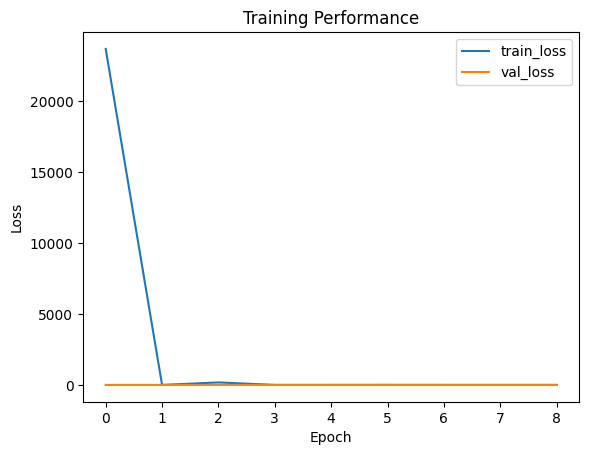

In [28]:
# Gráfico función de pérdida
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Training Performance')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [32]:
# Sistema de recomendación alternativo para nuevos usuarios (sin embeddings)
# Creo matriz usuario-película
user_movie_matrix = peresys_df.pivot_table(
    index='user_code',
    columns='movie_code',
    values='rating',
    fill_value=0
)

def new_user_recommendation(input_ratings):
    # Convertir ratings a vector
    new_user_vector = np.zeros(user_movie_matrix.shape[1])
    for title, rating in input_ratings.items():
        if title in title_to_code:
            movie_code = title_to_code[title]
            new_user_vector[movie_code] = rating
    
    # Calculo similitud con usuarios existentes
    similarities = cosine_similarity([new_user_vector], user_movie_matrix)[0]
    similar_users = np.argsort(similarities)[::-1][:10]  # Top 10 usuarios más similares
    
    # Obtengo IDs originales y porcentajes de similitud
    top_user_codes = user_movie_matrix.index[similar_users]
    top_user_ids = user_encoder.inverse_transform(top_user_codes)
    similarity_percentages = np.round(similarities[similar_users] * 100, 2)
    
    # Obtengo películas mejor valoradas por usuarios similares
    similar_users_data = peresys_df[
        (peresys_df["user_code"].isin(top_user_codes)) &
        (peresys_df["rating"] >= 4)
    ]
    
    # Excluyo películas ya valoradas
    rated_movies = [title_to_code[title] for title in input_ratings.keys() 
                   if title in title_to_code]
    similar_users_data = similar_users_data[~similar_users_data["movie_code"].isin(rated_movies)]
    
    # Agrupo y ordeno recomendaciones
    recommendations = similar_users_data.groupby("movie_code").agg(
        title=("title", "first"),
        year=("year", "first"),
        filmmaker=("filmmaker", "first"),
        user_count=("user_code", "count")
    ).sort_values("user_count", ascending=False).head(15)
    
    return recommendations, top_user_ids, similarity_percentages

In [34]:
# Interfaz de usuario
print("\n¡Bienvenido a PERESYS!")
print("Por favor, valora las siguientes películas (1-5):\n")

user_ratings = {}
for movie in input_movies:
    while True:
        try:
            rating = float(input(f"{movie}: "))
            if 1 <= rating <= 5:
                user_ratings[movie] = rating
                break
            else:
                print("Error: La valoración debe estar entre 1 y 5")
        except:
            print("Error: Introduce un número válido")

# Obtengo recomendaciones
recommendations, similar_users, similarities = new_user_recommendation(user_ratings)

# Muestro usuarios similares
print("\nLos 10 usuarios con gustos más cercanos a ti son:")
for user_id, sim in zip(similar_users, similarities):
    print(f"User ID: {user_id} - Similitud: {sim}%")

# Muestro recomendaciones
print("\nPelículas recomendadas basadas en tus almas gemelas:")
if not recommendations.empty:
    print(recommendations[['title', 'year', 'filmmaker']].drop_duplicates().to_string(index=False))
else:
    print("No hay suficientes recomendaciones disponibles.")


¡Bienvenido a PERESYS!
Por favor, valora las siguientes películas (1-5):


Los 10 usuarios con gustos más cercanos a ti son:
User ID: 147589 - Similitud: 69.52%
User ID: 55852 - Similitud: 68.13%
User ID: 20855 - Similitud: 67.6%
User ID: 194141 - Similitud: 65.66%
User ID: 47180 - Similitud: 65.32%
User ID: 121104 - Similitud: 64.66%
User ID: 70697 - Similitud: 64.41%
User ID: 45464 - Similitud: 64.03%
User ID: 158160 - Similitud: 63.96%
User ID: 196211 - Similitud: 63.66%

Películas recomendadas basadas en tus almas gemelas:
                                        title  year            filmmaker
The Lord of the Rings: The Return of the King  2003        Peter Jackson
        The Lord of the Rings: The Two Towers  2002        Peter Jackson
                                The Godfather  1972 Francis Ford Coppola
                              The Dark Knight  2008    Christopher Nolan
                           The Usual Suspects  1995         Bryan Singer
                      Raider

In [35]:
# Guardar el modelo en formato HDF5
modeloNCF.save('modelo5NCF.h5')